In [31]:
import numpy as np
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
df=pd.read_csv('/content/generated_emails.csv')

In [33]:
df

email_subject  \
0           Printer Not Working   
1             Leave Application   
2           Printer Not Working   
3           Access Denied Issue   
4          Meeting Room Booking   
..                          ...   
195        Policy Clarification   
196         Access Denied Issue   
197            Onboarding Query   
198  Software Installation Help   
199           Leave Application   

                                            email_body category  
0    Team,\nAccess to the project folder is denied....       IT  
1    Hello HR,\nI need to apply for sick leave from...       HR  
2    Team,\nAccess to the project folder is denied....       IT  
3    Team,\nAccess to the project folder is denied....       IT  
4    Hi Admin,\nThe cafeteria hygiene needs improve...    Other  
..                                                 ...      ...  
195  Hi Team,\nWhat are the onboarding steps for ne...       HR  
196  Dear IT Support,\nThe office printer is not wo...       IT  
197  Dear HR,\nI need clarification on the new leav...       HR  
198  Hello,\nMy email is not syncing with Outlook. ...       IT  
199  Dear HR,\nI need clarification on the new leav...       HR  

[200 rows x 3 columns]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   email_subject  200 non-null    object
 1   email_body     200 non-null    object
 2   category       200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [35]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
df['email_subject']=df['email_subject'].fillna('')
df['email_body']=df['email_body'].fillna('')

In [37]:
df['full_text']=df['email_subject']+' '+df['email_body']

In [38]:
df.drop(['email_subject','email_body'],axis=1,inplace=True)

In [39]:
def clean_text(text):
  text=text.lower()

  text=re.sub(r'http\S+|www\S+|https\S+','', text, flags=re.MULTILINE)

  text=re.sub(r'@\w+', '', text)

  text=re.sub(r'#\w+','', text)

  text = text.translate(str.maketrans('', '', string.punctuation))

  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [40]:
df['clean_text']=df['full_text'].apply(clean_text)

In [41]:
df.head()

category                                          full_text  \
0       IT  Printer Not Working Team,\nAccess to the proje...   
1       HR  Leave Application Hello HR,\nI need to apply f...   
2       IT  Printer Not Working Team,\nAccess to the proje...   
3       IT  Access Denied Issue Team,\nAccess to the proje...   
4    Other  Meeting Room Booking Hi Admin,\nThe cafeteria ...   

                                          clean_text  
0  printer not working team access to the project...  
1  leave application hello hr i need to apply for...  
2  printer not working team access to the project...  
3  access denied issue team access to the project...  
4  meeting room booking hi admin the cafeteria hy...

In [42]:
stop_words = set(stopwords.words('english'))

In [43]:
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [44]:
df['text_without_stopwords'] = df['clean_text'].apply(remove_stopwords)

In [45]:
lemmatizer = WordNetLemmatizer()

In [46]:
def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [47]:
df['preprocessed_text'] = df['text_without_stopwords'].apply(lemmatize_text)

In [48]:
df.head()

category                                          full_text  \
0       IT  Printer Not Working Team,\nAccess to the proje...   
1       HR  Leave Application Hello HR,\nI need to apply f...   
2       IT  Printer Not Working Team,\nAccess to the proje...   
3       IT  Access Denied Issue Team,\nAccess to the proje...   
4    Other  Meeting Room Booking Hi Admin,\nThe cafeteria ...   

                                          clean_text  \
0  printer not working team access to the project...   
1  leave application hello hr i need to apply for...   
2  printer not working team access to the project...   
3  access denied issue team access to the project...   
4  meeting room booking hi admin the cafeteria hy...   

                              text_without_stopwords  \
0  printer working team access project folder den...   
1  leave application hello hr need apply sick lea...   
2  printer working team access project folder den...   
3  access denied issue team access project folder...   
4  meeting room booking hi admin cafeteria hygien...   

                                   preprocessed_text  
0  printer working team access project folder den...  
1  leave application hello hr need apply sick lea...  
2  printer working team access project folder den...  
3  access denied issue team access project folder...  
4  meeting room booking hi admin cafeteria hygien...

In [49]:
df.drop(['full_text','clean_text','text_without_stopwords'],axis=1,inplace=True)

In [50]:
df.head()

category                                  preprocessed_text
0       IT  printer working team access project folder den...
1       HR  leave application hello hr need apply sick lea...
2       IT  printer working team access project folder den...
3       IT  access denied issue team access project folder...
4    Other  meeting room booking hi admin cafeteria hygien...

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,min_df=5, max_df=0.8)
X = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

In [52]:
label_encoder=LabelEncoder()

In [53]:
y=label_encoder.fit_transform(df['category'])

In [54]:
print(f"\nOriginal categories: {df['category'].unique()}")
print(f"Encoded categories (y): {y[:5]} (e.g., {label_encoder.inverse_transform(y[:5])})")
print(f"Mapping: {list(label_encoder.classes_)}")


Original categories: ['IT' 'HR' 'Other']
Encoded categories (y): [1 0 1 1 2] (e.g., ['IT' 'HR' 'IT' 'IT' 'Other'])
Mapping: ['HR', 'IT', 'Other']


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [58]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}



--- Training Logistic Regression ---
Evaluation for Logistic Regression:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      1.00      1.00         9
          IT       1.00      1.00      1.00        22
       Other       1.00      1.00      1.00         9

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



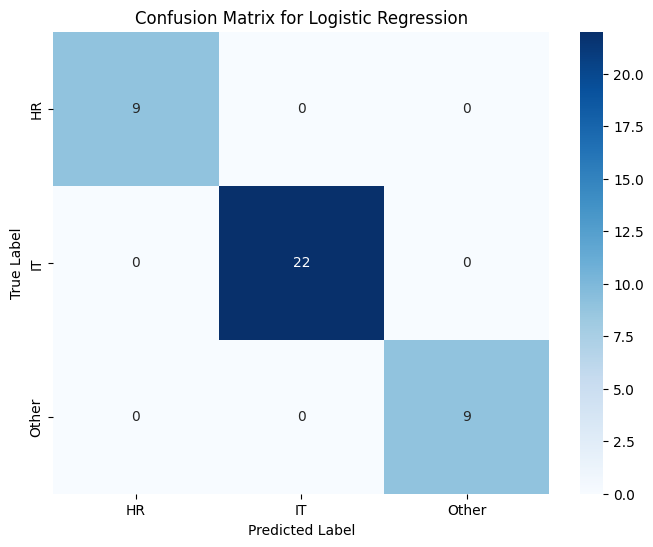


--- Training Random Forest ---
Evaluation for Random Forest:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      1.00      1.00         9
          IT       1.00      1.00      1.00        22
       Other       1.00      1.00      1.00         9

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



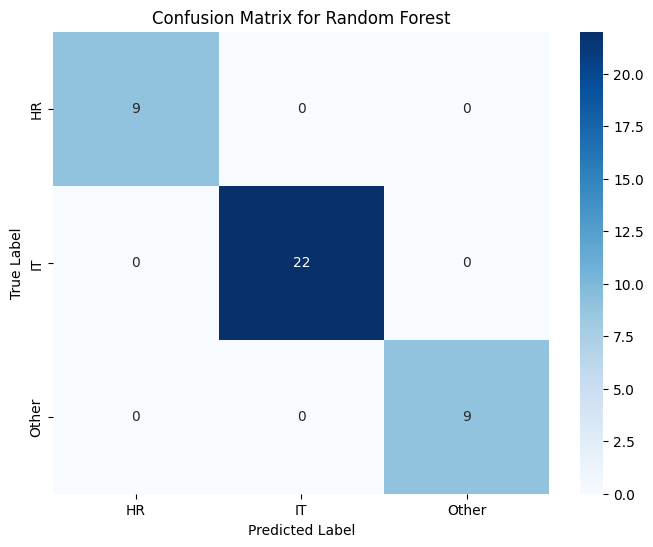


--- Training XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost:
Accuracy: 0.9750

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      0.89      0.94         9
          IT       1.00      1.00      1.00        22
       Other       0.90      1.00      0.95         9

    accuracy                           0.97        40
   macro avg       0.97      0.96      0.96        40
weighted avg       0.98      0.97      0.97        40



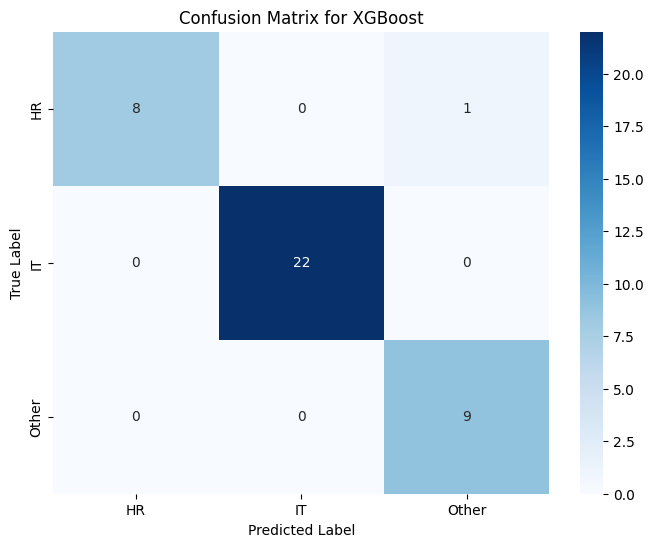

In [59]:
trained_models = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store the trained model
    trained_models[name] = model

    print(f"Evaluation for {name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [61]:
import pickle
best_model_name = "Logistic Regression" # You can change this based on performance
with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(trained_models[best_model_name], f)
print(f"\nSaved {best_model_name} as 'classifier_model.pkl' for Streamlit deployment.")



Saved Logistic Regression as 'classifier_model.pkl' for Streamlit deployment.
